# Welcome and have fun learning Logistic Regession with plug and play Neural Network

#### You are dealing with a **heavly skewed** dataset when some classes are much more frequent than others. **Accuracy** is not the perferred performance measure for classifiers.

<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

**Notes:**
Run time -
4 hours and 31 minutes 4000000 samples
3318.3s 395712 samples
4375.7s 1468136 samples
12905.1s 2262087 samples
5555.3s - GPU 2262087 samples

## Imports and Configuration ##

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow.keras as keras
# import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
import math
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 

EPOCHS = 177      # Does not matter with Early stopping.
BATCH_SIZE = 2048 # large enough to fit RAM
ACTIVATION = 'swish' # swish relu selu ;swish seem to work better with dropout layer
FOLDS = 5        # Only 5 or 10.
LEARNING_RATE = 0.000965713 # Optimal lr is about half the maximum lr
LR_FACTOR = 0.5   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 21  # Early stopping
DROPOUT = 0.1     # Act like L1 L2 regulator.

OPTIMIZER= 'adam' #adam adamax
LOSS='sparse_categorical_crossentropy' # sparse_categorical_crossentropy categorical_crossentropy
METRICS='sparse_categorical_accuracy'  # accuracy categorical_accuracy
ACC_VAL_METRICS = 'val_sparse_categorical_accuracy' # 'val_acc' val_sparse_categorical_accuracy
ACC_METRICS = 'sparse_categorical_accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 11426  # For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3     # speed trial any% Not used here

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"         # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [3]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Reduce Memory usage

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# Feature Engineering
These features are borrowed from https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering
Do read dataset description from https://www.kaggle.com/c/forest-cover-type-prediction/data

In [5]:
def feature_engineer(df):
#     # Euclidean distance to Hydrology
    df["ecldn_dist_hydrlgy"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    # Manhhattan distance to Hydrology
    df["mnhttn_dist_hydrlgy"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])
    
#     df['hydro_elevationecldn'] = df['Elevation'] + df['ecldn_dist_hydrlgy'] # ecldn_dist_hydrlgy
#     df['hydro_elevationmnhttn'] = df['Elevation'] + df['mnhttn_dist_hydrlgy'] # ecldn_dist_hydrlgy
    df['hydro_elevation'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology'] # ecldn_dist_hydrlgy
    df['binned_elevation'] = [math.floor(v/50.0) for v in df['Elevation']]
    
    df.loc[df["Aspect"] < 0, "Aspect"] += 360
    df.loc[df["Aspect"] > 359, "Aspect"] -= 360
    
    # Transform Cyclic Ordinal attributes to X y coordinates. 0 degree will be group with 359 degree etc.
#     df['AspectX'] = np.sin(2.*np.pi*df.Aspect/360)
#     df['Aspecty'] = np.cos(2.*np.pi*df.Aspect/360)

    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    df["soil_type_count"] = df[soil_features].sum(axis=1)

    wilderness_features = [x for x in df.columns if x.startswith("Wilderness_Area")]
    df["wilderness_area_count"] = df[wilderness_features].sum(axis=1)
    
    df['soil_Type12_32'] = df['Soil_Type32'] + df['Soil_Type12']
    df['soil_Type23_22_32_33'] = df['Soil_Type23'] + df['Soil_Type22'] + df['Soil_Type32'] + df['Soil_Type33']

    # code to replace all negative value with 0
    df['Horizontal_Distance_To_Roadways'][df['Horizontal_Distance_To_Roadways'] < 0] = 0
    df['horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in df['Horizontal_Distance_To_Roadways']]
    df['Horizontal_Distance_To_Fire_Points'][df['Horizontal_Distance_To_Fire_Points'] < 0] = 0
    df['horizontal_Distance_To_Fire_Points_Log'] = [math.log(v+1) for v in df['Horizontal_Distance_To_Fire_Points']]

    features_Hillshade = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
#     df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] += 360
#     df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] += 360
#     df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] += 360
#     df['Hillshade_9am_AspectX'] = np.sin(2.*np.pi*df.Hillshade_9am/360)
#     df['Hillshade_9am_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_9am/360)
#     df['Hillshade_Noon_AspectX'] = np.sin(2.*np.pi*df.Hillshade_Noon/360)
#     df['Hillshade_Noon_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_Noon/360)
#     df['Hillshade_3pm_AspectX'] = np.sin(2.*np.pi*df.Hillshade_3pm/360)
#     df['Hillshade_3pm_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_3pm/360)
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    df["hillshade_mean"] = df[features_Hillshade].mean(axis=1)
    df['hillshade_amp'] = df[features_Hillshade].max(axis=1) - df[features_Hillshade].min(axis=1)
    
#     df.drop(["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"], axis=1, inplace=True)
    
    return df

In [6]:
from pathlib import Path
def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    # Merge the splits so we can process them together
#     df = pd.concat([df_train, df_test])
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
    df_train = impute(df_train)
    df_test = impute(df_test)
    df_train = feature_engineer(df_train)
    df_test = feature_engineer(df_test)
    df_train = reduce_mem_usage(df_train)
    df_test = reduce_mem_usage(df_test)
    
    # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
    return df_train, df_test

# Load Data #

And now we can call the data loader and get the processed data splits:

In [7]:
train_data, test_data = load_data()

C:\Users\furyx\AppData\Local\Temp/ipykernel_5704/351918004.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizontal_Distance_To_Roadways'][df['Horizontal_Distance_To_Roadways'] < 0] = 0
C:\Users\furyx\AppData\Local\Temp/ipykernel_5704/351918004.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizontal_Distance_To_Fire_Points'][df['Horizontal_Distance_To_Fire_Points'] < 0] = 0


Mem. usage decreased to 377.66 Mb (81.8% reduction)
Mem. usage decreased to 93.46 Mb (81.7% reduction)


In [8]:
column_y = train_data.columns.difference(test_data.columns)[0] # column_y target_col

In [9]:
#customized XY TBR
idx = train_data[train_data[column_y] == 5].index
train_data.drop(idx, axis=0, inplace=True)
cols = ["Soil_Type7", "Soil_Type15"]
train_data.drop(cols, axis=1, inplace=True)
test_data.drop(cols, axis=1, inplace=True)

In [10]:
X = train_data.drop(columns=column_y)
y = train_data[[column_y]]

X_test = test_data.iloc[:,:]

gc.collect()

22

# Undersampling
For experiment measurements

## For quick test
TomekLinks
(array([1, 2, 3, 4, 5, 6, 7]),
 array([1390684, 2169226,  155218,     218,       1,    7627,   38757]))

In [11]:
# Check NA
missing_val = X.isnull().sum()
print(missing_val[missing_val > 0])

from sklearn.model_selection import train_test_split 
# For small testing batch
# X, X_val, y, y_val = train_test_split(X, y, train_size = VALIDATION_SPLIT, random_state = RANDOM_STATE)
# X = X.sample(n=SAMPLE, random_state=RANDOM_STATE)
# y = y.sample(n=SAMPLE, random_state=RANDOM_STATE)
# X_test = X_test.sample(n=SAMPLE, random_state=RANDOM_STATE)

# undersample = TomekLinks(sampling_strategy='auto') #, random_state=RANDOM_STATE not minority RandomUnderSampler
# X_under, y_under = undersample.fit_resample(X, y)

Series([], dtype: int64)


In [12]:
# Uncomment to peek at samples across all targets.
small_sampling = train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 977)))
small_sampling

Elevation  Aspect  Slope  \
Cover_Type Id                                  
1          3840232       3073      71      8   
           3908834       3314     359     16   
           3311294       3297     322      4   
           120597        3249     100     11   
           2451647       3512      95     12   
...                       ...     ...    ...   
7          3682627       3429     216     16   
           409923        3324      45     15   
           348587        3453      24      7   
           179606        3313     351     26   
           3152754       3388       4      3   

                    Horizontal_Distance_To_Hydrology  \
Cover_Type Id                                          
1          3840232                               141   
           3908834                               601   
           3311294                               321   
           120597                                263   
           2451647                                96   
...                                              ...   
7          3682627                               261   
           409923                                100   
           348587                                992   
           179606                                 46   
           3152754                                94   

                    Vertical_Distance_To_Hydrology  \
Cover_Type Id                                        
1          3840232                              70   
           3908834                              25   
           3311294                               1   
           120597                               50   
           2451647                             106   
...                                            ...   
7          3682627                             -37   
           409923                               48   
           348587                                4   
           179606                                7   
           3152754                              25   

                    Horizontal_Distance_To_Roadways  Hillshade_9am  \
Cover_Type Id                                                        
1          3840232                             1347            202   
           3908834                             1041            232   
           3311294                             1604            222   
           120597                              2628            254   
           2451647                              760            243   
...                                             ...            ...   
7          3682627                              838            231   
           409923                              2211            171   
           348587                              3229            221   
           179606                              3231            234   
           3152754                             1434            139   

                    Hillshade_Noon  Hillshade_3pm  \
Cover_Type Id                                       
1          3840232             247            135   
           3908834             221            153   
           3311294             223            176   
           120597              214            153   
           2451647             217            163   
...                            ...            ...   
7          3682627             248            171   
           409923              241            142   
           348587              237            143   
           179606              228            125   
           3152754             194            135   

                    Horizontal_Distance_To_Fire_Points  ...  hydro_elevation  \
Cover_Type Id                                           ...                    
1          3840232                                3558  ...             3003   
           3908834                                 874  ...             3289   
           3311294                        

In [13]:
def plot_features(features):
    for feature in features:
        plt.rcParams["figure.figsize"] = (15,5)
        for ctype in list(small_sampling[column_y].unique()):
            values = small_sampling.loc[small_sampling[column_y] == ctype][feature].values
            plt.scatter(x=values, y=np.arange(values.size), label=f"{column_y} {ctype}")
        plt.title(feature)
        plt.legend()
        plt.show()

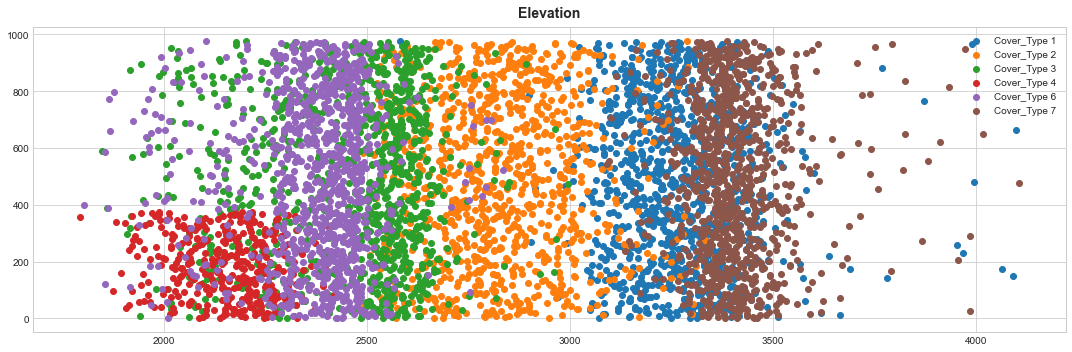

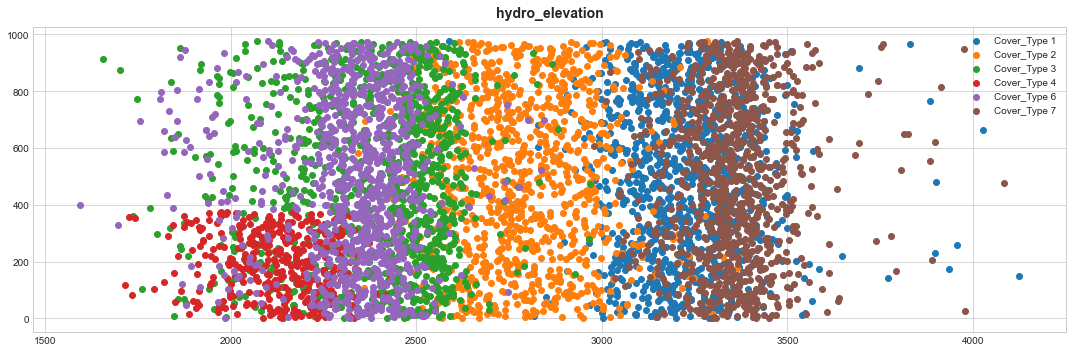

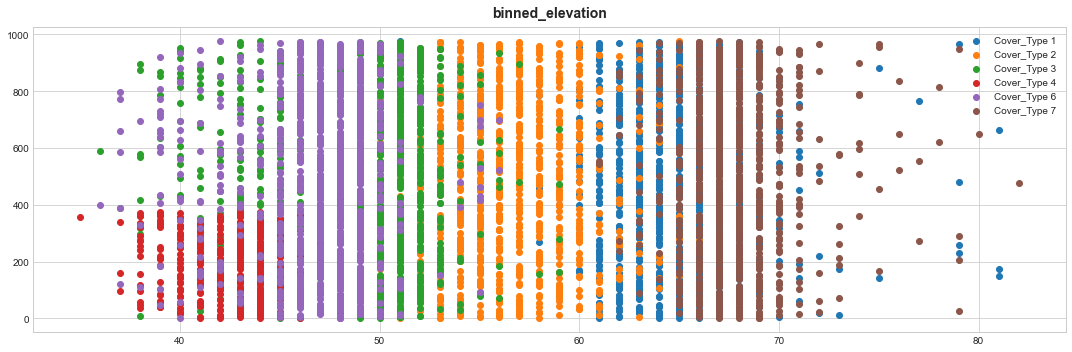

In [14]:
# Scatter plots for features with contnous values , 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'horizontal_Distance_To_Fire_Points_Log', 'hillshade_mean', 'hillshade_amp']
features_cols = ['Elevation',
                 'hydro_elevation',
                 'binned_elevation']

plot_features(features_cols)

In [15]:
sampling_key, sampling_count = np.unique(y, return_counts=True)
sampling_count[sampling_count > SAMPLE] = SAMPLE
zip_iterator = zip(sampling_key, sampling_count)
sampling_params = dict(zip_iterator)

In [16]:
# not minority
undersample = RandomUnderSampler(
    sampling_strategy=sampling_params, random_state=RANDOM_STATE)

X, y = undersample.fit_resample(X, y)

In [17]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 6, 7], dtype=int8),
 array([11426, 11426, 11426,   377, 11426, 11426], dtype=int64))

y to categorical

In [18]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y_cat = le.fit_transform(y[column_y])

In [19]:
# X_num = X.select_dtypes(include=[np.number])
# X_cat = X.select_dtypes(include=['object'])

In [20]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# for i in range(1,5):
#     X[f'Wilderness_Area{i}'] = le.fit_transform(Xf'Wilderness_Area{i}'])
#     X_test[f'Wilderness_Area{i}'] = le.fit_transform(X_test[f'Wilderness_Area{i}'])
# for i in range(1,41):
#     X[f'Soil_Type{i}'] = le.fit_transform(X[f'Soil_Type{i}'])
#     X_test[f'Soil_Type{i}'] = le.fit_transform(X_test[f'Soil_Type{i}'])

# Scaler transformer
By using RobustScaler(), we can remove the outliers
![](https://github.com/furyhawk/kaggle_practice/blob/main/images/Scalers.png?raw=true)

In [21]:
transformer_all_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_all_cols, X.columns[:]),
)

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

$Softmax: \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$


In [22]:
# try: # detect TPUs
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # detect GPUs
# #     strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
#     #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

# print("Number of accelerators: ", strategy.num_replicas_in_sync)
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU

def load_model():
    
    early_stopping = EarlyStopping(
        patience=ES_PATIENCE,
        min_delta=0,
        monitor= ACC_VAL_METRICS,
        mode='max',
        restore_best_weights=True,       
        baseline=None,
        verbose=VERBOSE,
    )
    plateau = ReduceLROnPlateau(
            patience=RLRP_PATIENCE,
            factor=LR_FACTOR,
            monitor='val_loss', 
            mode='min',
            verbose=VERBOSE,
    )

# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    # instantiating the model in the strategy scope creates the model on the TPU
#     with strategy.scope():
    model = keras.Sequential([
    layers.BatchNormalization(input_shape = [X.shape[-1]], name='input'),
    layers.Dense(300, kernel_initializer="lecun_normal", activation=ACTIVATION),
    # layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(200, kernel_initializer="lecun_normal", activation=ACTIVATION),
    # layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(100, kernel_initializer="lecun_normal", activation=ACTIVATION),
    # layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(50, kernel_initializer="lecun_normal", activation=ACTIVATION),
    # layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(le.classes_.shape[-1], activation = 'softmax'), #y_cat.shape[-1]
    ])

# -----------------------------------------------------------------
# sparse_categorical_crossentropy
    model.compile(
        optimizer=OPTIMIZER, #tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), Adamax adam
        loss=LOSS, # sparse_categorical_crossentropy categorical_crossentropy
        metrics=[METRICS], # acc sparse_categorical_accuracy
    )

    return model, early_stopping, plateau

# Performance Measures
## StratifiedKFold
Perform stratified sampling to produce folds that contain a representative ratio of each class.

In [23]:
kf = StratifiedKFold(n_splits=FOLDS,random_state=RANDOM_STATE,shuffle=True)

In [24]:
X_train_transformed = preprocessor.fit_transform(X)
X_test = preprocessor.transform(test_data)

In [25]:
# resets
preds_valid_f = {}
preds_test = np.zeros((1, 1)) # []
total_acc = []
f_scores = []

for fold,(train_index, valid_index) in enumerate(kf.split(X=X, y=y.Cover_Type)):

    X_train, X_valid = X_train_transformed[train_index], X_train_transformed[valid_index]
    y_train, y_valid = y_cat[train_index], y_cat[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid = valid_index.tolist()
#     index_valid  = X_valid.index.tolist()
#     X_train = preprocessor.fit_transform(X_train)
#     X_valid = preprocessor.transform(X_valid)
    
    #  ----------------------------------------------------------    
    # Model
    model, early_stopping, plateau  = load_model()

    history = model.fit( X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size      = BATCH_SIZE, 
                epochs          = EPOCHS,
                callbacks       = [early_stopping, plateau],
                shuffle         = True,
                verbose         = VERBOSE,
              )
    
    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE)
    
    #  ----------------------------------------------------------
    #  test dataset predictions for submission np.argmax(, axis=1) + 1
#     preds_test.append( le.inverse_transform(np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)) )
    preds_test = preds_test + model.predict(X_test, batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores
        model.summary()
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)

    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, le.inverse_transform(np.argmax(preds_valid, axis=1)))))
    # Getting score for a fold model
    fold_acc = accuracy_score(y.iloc[valid_index].Cover_Type, le.inverse_transform(np.argmax(preds_valid, axis=1)))
    print(f"Fold {fold} accuracy_score: {fold_acc}")

    # Total acc
    total_acc.append(fold_acc)
    
    del model
    gc.collect()

print(f"mean accuracy_score: {np.mean(total_acc)}, std: {np.std(total_acc)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (BatchNormalization)   (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 300)               19500     
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

# Evaluation

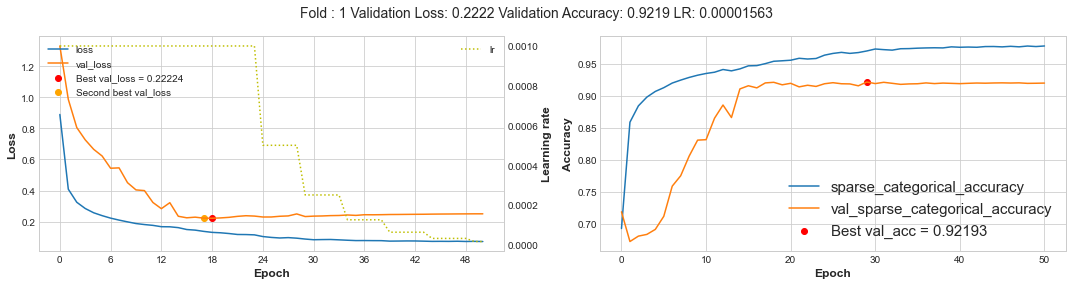

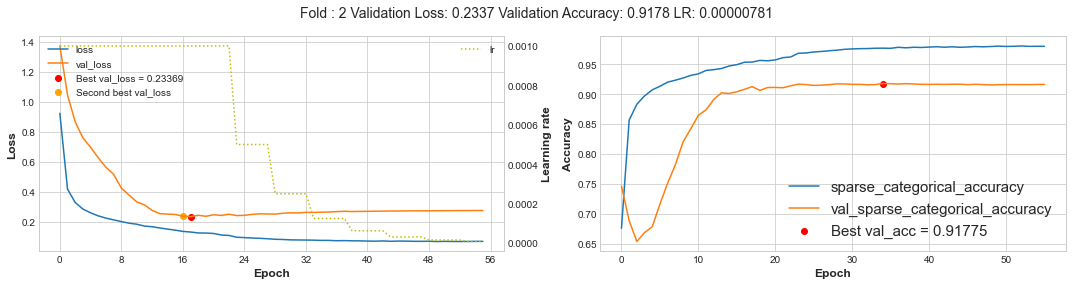

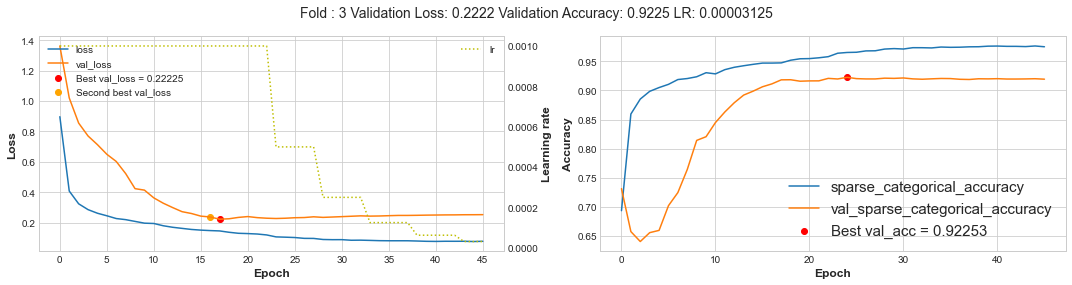

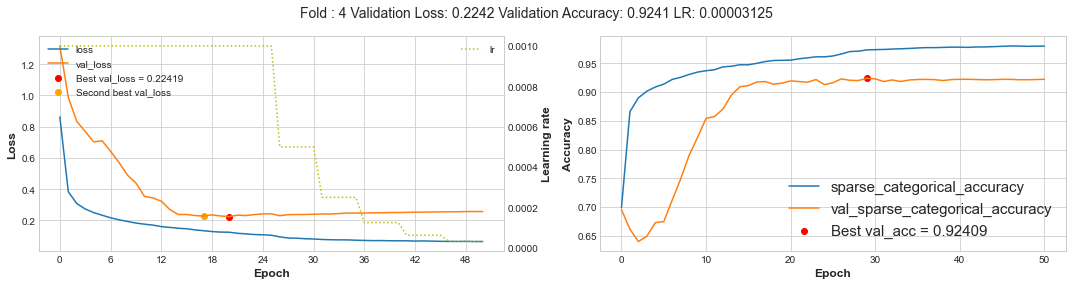

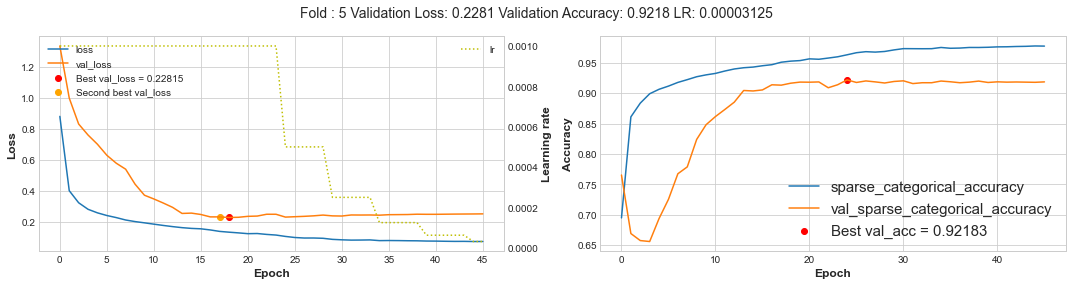

In [26]:
def plot_acc(f_scores):
    for fold in range(f_scores['folds'].nunique()):
        history_f = f_scores[f_scores['folds'] == fold]
        
        best_epoch = np.argmin(np.array(history_f['val_loss']))
        best_val_loss = history_f['val_loss'][best_epoch]

        fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

        fig.suptitle('Fold : '+ str(fold+1) +
                     " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                     " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                     " LR: {:0.8f}".format(history_f['lr'].min())
                     , fontsize=14)

        plt.subplot(1,2,1)
        plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
                
        from_epoch = 0
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
            almost_val_loss = history_f['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')        
        
        ax2 = plt.gca().twinx()
        ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')
        ax2.grid()

        best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
        best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]
        
        plt.subplot(1,2,2)
        plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_acc], c='r', label=f'Best val_acc = {best_val_acc:.5f}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower left')    
        plt.legend(fontsize=15)
        plt.grid(b=True, linestyle='-')

plot_acc(f_scores)

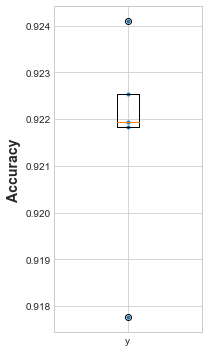

In [27]:
plt.figure(figsize=(3, 5))
plt.plot([1]*FOLDS, total_acc, ".")
plt.boxplot([total_acc], labels=("y"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

## Confusion matrix

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$



In [28]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis=1),
        'precision': cm / cm.sum(axis=0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(15,5))
    ax = ax.flatten()

    mask = (np.eye(cm.shape[0]) == 0) * 1

    for idx, (name, matrix) in enumerate(metrics.items()):

        ax[idx].set_title(name)

        sns.heatmap(
            data=matrix,
            cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar=False,
#             mask=mask,
            lw=0.25,
            annot=True,
            fmt='.2f',
            ax=ax[idx]
        )
    sns.despine()

In [29]:
oof_y_hat = []
for key, value in sorted(preds_valid_f.items()):
    oof_y_hat.append(value)

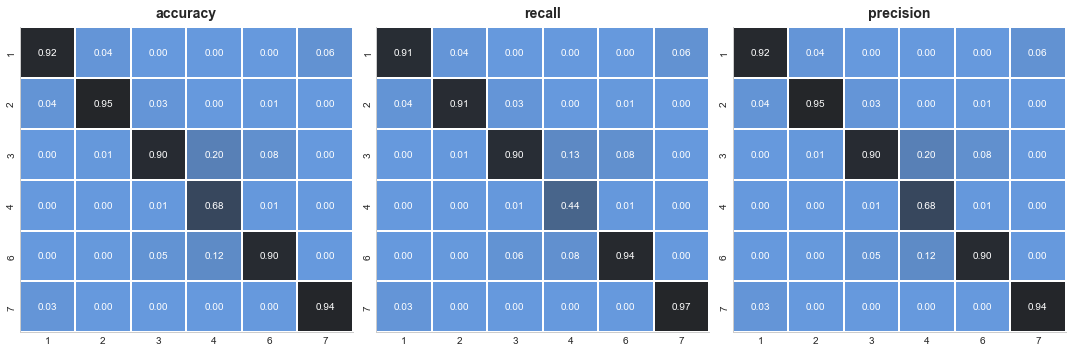

In [30]:
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data=confusion_matrix(y, oof_y_hat, labels=le.classes_), index=le.classes_, columns=le.classes_)
plot_cm(cm)

In [31]:
confusion_matrix(y, oof_y_hat, labels=le.classes_)

array([[10372,   402,     2,     0,     0,   650],
       [  507, 10413,   393,     0,    84,    29],
       [    1,   125, 10302,    50,   948,     0],
       [    0,     0,   114,   165,    98,     0],
       [    1,    53,   629,    29, 10714,     0],
       [  386,     6,     0,     0,     0, 11034]], dtype=int64)

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [32]:
preds_test.shape

(1000000, 6)

In [33]:
# le.inverse_transform(np.argmax(preds_test, axis=1))

# Submission

In [34]:
# preds_test = np.argmax(preds_test, axis=1)
# preds_test = le.inverse_transform(preds_test)

sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[column_y] = le.inverse_transform(np.argmax(preds_test, axis=1)) # (stats.mode(preds_test)[0][0]) preds_test[FOLDS-1] # argmax reverse of to_categorical sub[column_y] = (np.argmax(sum(preds_test), axis=1) + 1)
sub.to_csv('submission.csv', index=False)
sub

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
...,...,...
999995,4999995,2
999996,4999996,1
999997,4999997,2
999998,4999998,1


In [35]:
np.unique(sub[column_y], return_counts=True)

(array([1, 2, 3, 4, 6, 7], dtype=int8),
 array([378674, 476274,  80375,    664,  25828,  38185], dtype=int64))

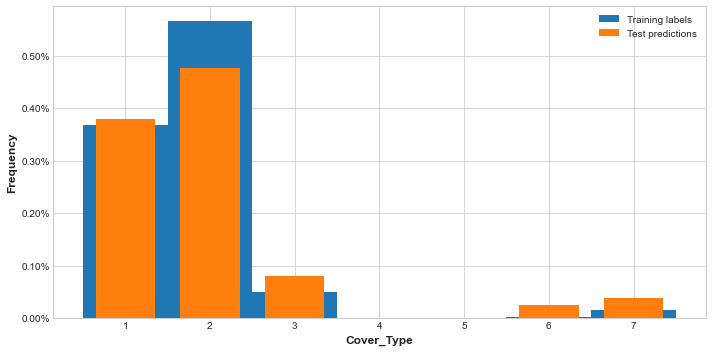

In [36]:
# Plot the distribution of the test predictions vs training set
plt.figure(figsize=(10,5))
plt.hist(train_data[column_y], bins=np.linspace(0.5, 7.5, 8), density=True, label='Training labels')
plt.hist(sub[column_y], bins=np.linspace(0.5, 7.5, 8), density=True, rwidth=0.7, label='Test predictions')
plt.xlabel(column_y)
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.show()


C:\Users\furyx\AppData\Local\Temp/ipykernel_5704/4084774749.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


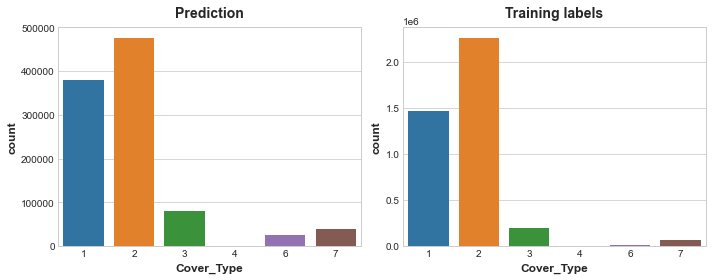

In [37]:
# Plot the distribution of the test predictions
fig, ax =plt.subplots(1,2,figsize=(10,4))
sns.countplot(x = sub[column_y], ax=ax[0], orient="h").set_title("Prediction")
# Plot the distribution of the training set
sns.countplot(x = train_data[column_y], ax=ax[1], orient="h").set_title("Training labels")
fig.show()

keys_list, values_list = np.unique(my_list, return_counts=True)keys_list, values_list = np.unique(my_list, return_counts=True)To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/tabular-playground-series-dec-2021/code) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

In [38]:
# np.array(preds_test).shape